# House Prices: Advanced Regression Maching Learning Project
Objective: Analyze the housing dataset to find key features that influence sale price and develop a machine learning model to predict the prices

- <a href="#Packages">Packages</a><br>
- <a href="#Data Import and Set-Up">Data Import and Set-Up</a><br>
- <a href="#Missing Data">Missing Data</a><br>
- <a href="#Feature Engineering">Feature Engineering</a><br>
- <a href="#Feature Selection">Feature Selection</a><br>
- <a href="#Algorithm Selection">Algorithm Selection</a><br>
    - <a href="#Random Forest">Random Forest</a><br>
    - <a href="#Random Forest Prediction">Random Forest Prediction</a><br>
    - <a href="#Gradient Boosting">Gradient Boosting</a><br>
    - <a href="#GBR Prediction">GBR Prediction</a><br>


<p><a name="Packages"></a></p>

# Packages

In [295]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn import preprocessing
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, accuracy_score
from collections import OrderedDict
L = LinearRegression(n_jobs=-1)
from functools import reduce
import sklearn
import sklearn.ensemble
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.feature_selection import chi2, f_regression, f_classif, mutual_info_classif,\
mutual_info_regression 
from sklearn.feature_selection import SelectKBest, SelectFromModel, VarianceThreshold

<p><a name="Data Import and Set-Up"></a></p>

# Data Import and Set-Up

In [296]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

## Drop Outliers

Per F-Test, __GrLivArea__ is statistically significant. Therefore, I checked for any outliers and removed them
* Accepted z-score with less than or equal to 3

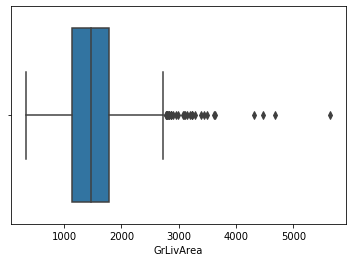

In [297]:
sns.boxplot(x=train['GrLivArea'])

In [298]:
train = train.loc[abs(stats.zscore(train['GrLivArea']))<=3]

## y value and Concat datasets

In [299]:
y = train['SalePrice'].reset_index(drop=True)
combine = pd.concat([train,test], axis=0, sort=False)

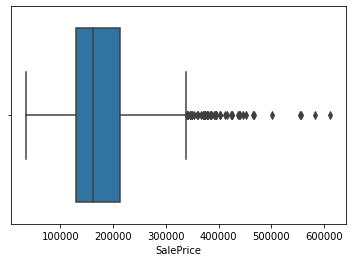

In [300]:
sns.boxplot(x=y)

<p><a name="Missing Data"></a></p>

# Missing Data

Identify missing data and decide whether to delete or impute

In [301]:
missing = dict(combine.isnull().sum().sort_values(ascending=False)[:20])

In [302]:
for key, value in missing.items():
        missing_num = value/len(combine)
        print(key, missing_num)

PoolQC 0.9975887013434378
MiscFeature 0.9638305201515673
Alley 0.9321391663796073
Fence 0.8046848088184636
SalePrice 0.502583534274888
FireplaceQu 0.48880468480881845
LotFrontage 0.16672407853944196
GarageQual 0.054426455390974855
GarageYrBlt 0.054426455390974855
GarageFinish 0.054426455390974855
GarageCond 0.054426455390974855
GarageType 0.05373751291767138
BsmtExposure 0.028246641405442644
BsmtCond 0.028246641405442644
BsmtQual 0.027902170168790905
BsmtFinType2 0.027557698932139166
BsmtFinType1 0.027213227695487428
MasVnrType 0.00826730967964175
MasVnrArea 0.00792283844299001
MSZoning 0.0013778849466069584


## Delete Missing Data

In [303]:
def delete_missing(df):
    '''
    Delete columns with more than 80% missing values
    '''
    for key, value in missing.items():
        missing_num = value/len(combine)
        if key != 'SalePrice' and missing_num >= 0.8:
            del df[key]

In [304]:
delete_missing(combine)

In [305]:
# Because 'MiscFeature' has many null values, also will delete 'MiscVal'
del combine['MiscVal']

## Impute Missing Data

In [306]:
combine.isnull().sum().sort_values(ascending=False)[:30]

SalePrice       1459
FireplaceQu     1419
LotFrontage      484
GarageCond       158
GarageYrBlt      158
GarageFinish     158
GarageQual       158
GarageType       156
BsmtCond          82
BsmtExposure      82
BsmtQual          81
BsmtFinType2      80
BsmtFinType1      79
MasVnrType        24
MasVnrArea        23
MSZoning           4
Functional         2
BsmtFullBath       2
Utilities          2
BsmtHalfBath       2
BsmtFinSF1         1
Exterior2nd        1
BsmtFinSF2         1
BsmtUnfSF          1
Electrical         1
Exterior1st        1
TotalBsmtSF        1
SaleType           1
GarageArea         1
KitchenQual        1
dtype: int64

In [307]:
def fill_none_missing(df,features):
    '''
    Impute NaN with 'None'
    '''
    for feature in features:
        df[feature] = df[feature].fillna('None')
    return df

def fill_zero_missing(df,features):
    '''
    Impute NaN with 0
    '''
    for feature in features:
        df[feature] = df[feature].fillna(0)
    return df

def fill_mode_missing(df):
    '''
    Impute select NaN features with mode value
    '''
    df['LotFrontage'] = df['LotFrontage'].fillna(float(df['LotFrontage'].mode())) # impute with mode instaed of median
    df['MSZoning'] = df['MSZoning'].fillna('RL')
    df['Utilities'] = df['Utilities'].fillna('AllPub')
    df['Functional'] = df['Functional'].fillna('Typ')
    df['Electrical'] = df['Electrical'].fillna('SBrkr')
    df['Exterior2nd'] = df['Exterior2nd'].fillna('VinylSd')
    df['Exterior1st'] = df['Exterior1st'].fillna('VinylSd')
    df['SaleType'] = df['SaleType'].fillna('WD')
    df['KitchenQual'] = df['KitchenQual'].fillna('TA')
    return df

In [308]:
none_features = ['GarageQual','GarageYrBlt','GarageFinish','GarageCond','GarageType','FireplaceQu','BsmtCond','BsmtExposure','BsmtQual','BsmtFinType2','BsmtFinType1',
                'MasVnrType','MasVnrArea','GarageCars','GarageArea'] # added this last
zero_features = ['BsmtFullBath','BsmtHalfBath','BsmtUnfSF','BsmtFinSF1','BsmtFinSF2','TotalBsmtSF']


combine = fill_none_missing(combine,none_features)
combine = fill_zero_missing(combine,zero_features)
combine = fill_mode_missing(combine)
combine.shape

(2903, 76)

<p><a name="Feature Engineering"></a></p>

# Feature Engineering

## Numeric

In [309]:
combine.select_dtypes(include='number').info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2903 entries, 0 to 1458
Data columns (total 33 columns):
Id               2903 non-null int64
MSSubClass       2903 non-null int64
LotFrontage      2903 non-null float64
LotArea          2903 non-null int64
OverallQual      2903 non-null int64
OverallCond      2903 non-null int64
YearBuilt        2903 non-null int64
YearRemodAdd     2903 non-null int64
BsmtFinSF1       2903 non-null float64
BsmtFinSF2       2903 non-null float64
BsmtUnfSF        2903 non-null float64
TotalBsmtSF      2903 non-null float64
1stFlrSF         2903 non-null int64
2ndFlrSF         2903 non-null int64
LowQualFinSF     2903 non-null int64
GrLivArea        2903 non-null int64
BsmtFullBath     2903 non-null float64
BsmtHalfBath     2903 non-null float64
FullBath         2903 non-null int64
HalfBath         2903 non-null int64
BedroomAbvGr     2903 non-null int64
KitchenAbvGr     2903 non-null int64
TotRmsAbvGrd     2903 non-null int64
Fireplaces       2903 non-nu

### Consolidate the following features:
* Combined BsmtFullBath, BsmtHalfBath, FullBath, HalfBath to yield TotalBaths
    * Multiplied half baths by 0.5
* All PorchSF types to retrieve PorchSF
    * WoodDeckSF, OpenPorchSF, EnclosedPorch, 3SsnPorch, ScreenPorch
* TotalBsmtSF, 1stFlrSF, and 2ndFlrSF to yield TotalSF

### Convert the following feature:
* Convert MSSubClass to string type since the numerical values identify the type of dwelling involved in sale

In [310]:
def consolidate(df):
    ''' 
    Consolidate features into one to capture TotalBaths, TotalSF, and PorchSF
    Convert MSSubClass to a string type
    Drop features that were combined
    '''
    df['TotalBaths'] = df['FullBath'] + df['HalfBath'].apply(lambda x : x * 0.5) + df['BsmtFullBath'] + df['BsmtHalfBath'].apply(lambda x: x * 0.5)
    df['PorchSF'] = df['WoodDeckSF'] + df['OpenPorchSF'] + df['EnclosedPorch'] + df['3SsnPorch'] + df['ScreenPorch']
    df['MSSubClass'] = df['MSSubClass'].astype(str)
    df['TotalSF'] = df['TotalBsmtSF'] + df['1stFlrSF'] + df['2ndFlrSF']
    df = df.drop(['Id','BsmtFullBath','BsmtHalfBath','FullBath','HalfBath','WoodDeckSF','OpenPorchSF','EnclosedPorch','3SsnPorch','ScreenPorch',
                 'TotalBsmtSF','1stFlrSF','2ndFlrSF'], axis = 1)
    
    return df

In [311]:
combine = consolidate(combine)

In [312]:
combine.select_dtypes(include='number').info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2903 entries, 0 to 1458
Data columns (total 22 columns):
LotFrontage     2903 non-null float64
LotArea         2903 non-null int64
OverallQual     2903 non-null int64
OverallCond     2903 non-null int64
YearBuilt       2903 non-null int64
YearRemodAdd    2903 non-null int64
BsmtFinSF1      2903 non-null float64
BsmtFinSF2      2903 non-null float64
BsmtUnfSF       2903 non-null float64
LowQualFinSF    2903 non-null int64
GrLivArea       2903 non-null int64
BedroomAbvGr    2903 non-null int64
KitchenAbvGr    2903 non-null int64
TotRmsAbvGrd    2903 non-null int64
Fireplaces      2903 non-null int64
PoolArea        2903 non-null int64
MoSold          2903 non-null int64
YrSold          2903 non-null int64
SalePrice       1444 non-null float64
TotalBaths      2903 non-null float64
PorchSF         2903 non-null int64
TotalSF         2903 non-null float64
dtypes: float64(7), int64(15)
memory usage: 521.6 KB


In [313]:
# combine['LotArea'] = np.log(combine['LotArea'])
# combine['SalePrice'] = np.log(combine['SalePrice'])

## String

In [314]:
string_columns = combine.select_dtypes(exclude='number').columns

In [315]:
for i in string_columns:
    print(combine[i].unique())

['60' '20' '70' '50' '190' '45' '90' '120' '30' '85' '80' '160' '75' '180'
 '40' '150']
['RL' 'RM' 'C (all)' 'FV' 'RH']
['Pave' 'Grvl']
['Reg' 'IR1' 'IR2' 'IR3']
['Lvl' 'Bnk' 'Low' 'HLS']
['AllPub' 'NoSeWa']
['Inside' 'FR2' 'Corner' 'CulDSac' 'FR3']
['Gtl' 'Mod' 'Sev']
['CollgCr' 'Veenker' 'Crawfor' 'NoRidge' 'Mitchel' 'Somerst' 'NWAmes'
 'OldTown' 'BrkSide' 'Sawyer' 'NridgHt' 'NAmes' 'SawyerW' 'IDOTRR'
 'MeadowV' 'Edwards' 'Timber' 'Gilbert' 'StoneBr' 'ClearCr' 'NPkVill'
 'Blmngtn' 'BrDale' 'SWISU' 'Blueste']
['Norm' 'Feedr' 'PosN' 'Artery' 'RRAe' 'RRNn' 'RRAn' 'PosA' 'RRNe']
['Norm' 'Artery' 'RRNn' 'Feedr' 'PosA' 'PosN' 'RRAn' 'RRAe']
['1Fam' '2fmCon' 'Duplex' 'TwnhsE' 'Twnhs']
['2Story' '1Story' '1.5Fin' '1.5Unf' 'SFoyer' 'SLvl' '2.5Unf' '2.5Fin']
['Gable' 'Hip' 'Gambrel' 'Mansard' 'Flat' 'Shed']
['CompShg' 'WdShngl' 'Metal' 'WdShake' 'Membran' 'Tar&Grv' 'Roll']
['VinylSd' 'MetalSd' 'Wd Sdng' 'HdBoard' 'BrkFace' 'WdShing' 'CemntBd'
 'Plywood' 'AsbShng' 'Stucco' 'BrkComm' 'AsphShn' '

In [316]:
def convert_qual(df, columns):
    '''
    Convert quality and conditions string values to ordinal numerical values
    '''
    for i in columns:
        df[i][df[i] == 'None'] = 0
        df[i][df[i] == 'Po'] = 1
        df[i][df[i] == 'Fa'] = 2
        df[i][df[i] == 'TA'] = 3
        df[i][df[i] == 'Gd'] = 4
        df[i][df[i] == 'Ex'] = 5
        df[i] = df[i].astype('float64')
    return df

In [317]:
combine = convert_qual(combine, ['ExterQual','ExterCond','BsmtQual','BsmtCond','HeatingQC','KitchenQual',
                            'GarageQual','GarageCond'])

/Users/thisbekristin/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/thisbekristin/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/Users/thisbekristin/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/thisbekristin/opt/an

In [318]:
def convert_misc_qual(tr):
    '''
    Convert other misc. ordinal categorical variables to numeric ordinal variables and conver to float
    '''
    tr.LotShape[tr['LotShape']=='IR3'] = 1
    tr.LotShape[tr['LotShape']=='IR2'] = 2
    tr.LotShape[tr['LotShape']=='IR1'] = 3
    tr.LotShape[tr['LotShape']=='Reg'] = 4
    tr.LotShape = tr.LotShape.astype('float64')
    tr.BsmtExposure[tr['BsmtExposure']=='None'] = 0
    tr.BsmtExposure[tr['BsmtExposure']=='No'] = 1
    tr.BsmtExposure[tr['BsmtExposure']=='Mn'] = 2
    tr.BsmtExposure[tr['BsmtExposure']=='Av'] = 3
    tr.BsmtExposure[tr['BsmtExposure']=='Gd'] = 4
    tr.BsmtExposure = tr.BsmtExposure.astype('float64')
    tr.BsmtFinType1[tr['BsmtFinType1']=='None'] = 0
    tr.BsmtFinType1[tr['BsmtFinType1']=='Unf'] = 1
    tr.BsmtFinType1[tr['BsmtFinType1']=='LwQ'] = 2
    tr.BsmtFinType1[tr['BsmtFinType1']=='Rec'] = 3
    tr.BsmtFinType1[tr['BsmtFinType1']=='BLQ'] = 4
    tr.BsmtFinType1[tr['BsmtFinType1']=='ALQ'] = 5
    tr.BsmtFinType1[tr['BsmtFinType1']=='GLQ'] = 6
    tr.BsmtFinType1 = tr.BsmtFinType1.astype('float64')
    tr.BsmtFinType2[tr['BsmtFinType2']=='None'] = 0
    tr.BsmtFinType2[tr['BsmtFinType2']=='Unf'] = 1
    tr.BsmtFinType2[tr['BsmtFinType2']=='LwQ'] = 2
    tr.BsmtFinType2[tr['BsmtFinType2']=='Rec'] = 3
    tr.BsmtFinType2[tr['BsmtFinType2']=='BLQ'] = 4
    tr.BsmtFinType2[tr['BsmtFinType2']=='ALQ'] = 5
    tr.BsmtFinType2[tr['BsmtFinType2']=='GLQ'] = 6
    tr.BsmtFinType2 = tr.BsmtFinType2.astype('float64')
    tr.Functional[tr['Functional']=='None'] = 0 
    tr.Functional[tr['Functional']=='Sal'] = 1
    tr.Functional[tr['Functional']=='Sev'] = 2
    tr.Functional[tr['Functional']=='Maj2'] = 3
    tr.Functional[tr['Functional']=='Maj1'] = 4
    tr.Functional[tr['Functional']=='Mod'] = 5
    tr.Functional[tr['Functional']=='Min2'] = 6
    tr.Functional[tr['Functional']=='Min1'] = 7
    tr.Functional[tr['Functional']=='Typ'] = 8
    tr.Functional = tr.Functional.astype('float64') 
    tr.GarageFinish[tr['GarageFinish']=='None'] = 0
    tr.GarageFinish[tr['GarageFinish']=='Unf'] = 1
    tr.GarageFinish[tr['GarageFinish']=='RFn'] = 2
    tr.GarageFinish[tr['GarageFinish']=='Fin'] = 3
    tr.GarageFinish = tr.GarageFinish.astype('float64')
    tr.PavedDrive[tr['PavedDrive']=='N'] = 0
    tr.PavedDrive[tr['PavedDrive']=='P'] = 1
    tr.PavedDrive[tr['PavedDrive']=='Y'] = 2
    tr.PavedDrive = tr.PavedDrive.astype('float64')
    tr.CentralAir[tr['CentralAir']=='N'] = 0
    tr.CentralAir[tr['CentralAir']=='Y'] = 1
    tr.CentralAir = tr.CentralAir.astype('float64') 
    tr.LandSlope[tr['LandSlope']=='Gtl'] = 1
    tr.LandSlope[tr['LandSlope']=='Mod'] = 2
    tr.LandSlope[tr['LandSlope']=='Sev'] = 3
    tr.LandSlope = tr.LandSlope.astype('float64')
    return tr

In [319]:
combine = convert_misc_qual(combine)

/Users/thisbekristin/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/Users/thisbekristin/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/thisbekristin/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/Users/thisbekristin/opt

## 66 Columns after Feature Engineering
* Combine and consolidate features
* Convert string categorical data to numerical ordinal data

In [320]:
combine.shape

(2903, 66)

<p><a name="Feature Selection"></a></p>

# Feature Selection

In [321]:
# numerical features
combine.select_dtypes(include='number').info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2903 entries, 0 to 1458
Data columns (total 39 columns):
LotFrontage     2903 non-null float64
LotArea         2903 non-null int64
LotShape        2903 non-null float64
LandSlope       2903 non-null float64
OverallQual     2903 non-null int64
OverallCond     2903 non-null int64
YearBuilt       2903 non-null int64
YearRemodAdd    2903 non-null int64
ExterQual       2903 non-null float64
ExterCond       2903 non-null float64
BsmtQual        2903 non-null float64
BsmtCond        2903 non-null float64
BsmtExposure    2903 non-null float64
BsmtFinType1    2903 non-null float64
BsmtFinSF1      2903 non-null float64
BsmtFinType2    2903 non-null float64
BsmtFinSF2      2903 non-null float64
BsmtUnfSF       2903 non-null float64
HeatingQC       2903 non-null float64
CentralAir      2903 non-null float64
LowQualFinSF    2903 non-null int64
GrLivArea       2903 non-null int64
BedroomAbvGr    2903 non-null int64
KitchenAbvGr    2903 non-null int64

In [322]:
# string features
combine.select_dtypes(exclude='number').info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2903 entries, 0 to 1458
Data columns (total 27 columns):
MSSubClass       2903 non-null object
MSZoning         2903 non-null object
Street           2903 non-null object
LandContour      2903 non-null object
Utilities        2903 non-null object
LotConfig        2903 non-null object
Neighborhood     2903 non-null object
Condition1       2903 non-null object
Condition2       2903 non-null object
BldgType         2903 non-null object
HouseStyle       2903 non-null object
RoofStyle        2903 non-null object
RoofMatl         2903 non-null object
Exterior1st      2903 non-null object
Exterior2nd      2903 non-null object
MasVnrType       2903 non-null object
MasVnrArea       2903 non-null object
Foundation       2903 non-null object
Heating          2903 non-null object
Electrical       2903 non-null object
FireplaceQu      2903 non-null object
GarageType       2903 non-null object
GarageYrBlt      2903 non-null object
GarageCars       29

## F Test
* Due to possible SalePrice outliers, tested f_regression of numerical values against log of target value, SalePrice.
* Tested features are quantitative continuous or numerical ordinal

In [323]:
F_Test = combine[combine['SalePrice'].notnull()]

In [324]:
combine_numerical = F_Test.drop(F_Test.select_dtypes(exclude='number').columns.insert(0,'SalePrice'), axis=1)
value_f, p_f = f_regression(combine_numerical, np.log(F_Test['SalePrice']))

In [325]:
insig_FTest = pd.Series(p_f, index=combine_numerical.columns).sort_values()
insig_FTest

TotalSF          0.000000e+00
OverallQual      0.000000e+00
GrLivArea       3.441763e-222
ExterQual       6.499902e-202
KitchenQual     2.037484e-187
TotalBaths      3.273788e-185
BsmtQual        8.355812e-155
GarageFinish    2.013431e-151
YearBuilt       8.072310e-149
YearRemodAdd    8.969357e-126
TotRmsAbvGrd     3.619806e-99
Fireplaces       6.872906e-84
HeatingQC        4.880754e-82
PorchSF          2.749068e-52
BsmtFinSF1       2.426161e-51
GarageQual       1.553903e-47
GarageCond       8.367228e-47
CentralAir       1.474495e-44
BsmtExposure     2.421631e-43
BsmtFinType1     1.147741e-39
LotFrontage      1.364732e-37
PavedDrive       1.197632e-33
BsmtCond         1.133656e-27
LotShape         1.734579e-27
LotArea          3.527600e-21
BsmtUnfSF        1.315117e-16
BedroomAbvGr     9.533361e-13
KitchenAbvGr     1.061208e-08
Functional       2.839942e-08
LowQualFinSF     4.132819e-03
MoSold           1.022482e-02
OverallCond      8.001358e-02
ExterCond        1.416811e-01
YrSold    

In [326]:
insig_FTest[31::]

OverallCond     0.080014
ExterCond       0.141681
YrSold          0.165029
PoolArea        0.169011
LandSlope       0.298630
BsmtFinType2    0.443861
BsmtFinSF2      0.678372
dtype: float64

Text(0.5, 1.0, 'F-Test: Insignifcant Features')

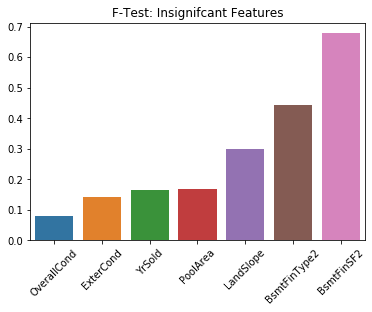

In [327]:
g = sns.barplot(x=insig_FTest[31::].index,y=insig_FTest[31::].values, orient="v")
g.set_xticklabels(g.get_xticklabels(),rotation=45)
g.set_title("F-Test: Insignifcant Features")

### F-Test Summary 

* After F-Test, the results call for more adjustments due to the following insignificant p-values
 - OverallCond
 - ExterCond
 - YrSold
 - PoolArea
 - LandSlope
 - BsmtFinType2
 - BsmtFinSF2
 
* Drop insignificant features to yield 59 features

In [328]:
combine = combine.drop(['OverallCond','ExterCond','YrSold','PoolArea','LandSlope','BsmtFinType2','BsmtFinSF2'], axis = 1)

In [329]:
combine.shape

(2903, 59)

# Export Data
For partner to use in Model Selection

In [330]:
# combine.to_csv('fulldataset.csv', index=False)

<p><a name="Algorithm Selection"></a></p>

# Algorithm Selection

**This workbook explores Random Forest and Gradient Boosting. Other Machine Learning Models can be found in a separate Jupyter Notebook**

<p><a name="Random Forest"></a></p>

# Random Forest

In [1308]:
from sklearn import ensemble
import sklearn.model_selection as ms
randomForest = ensemble.RandomForestRegressor()

# fit RF model on training set
randomForest.set_params(random_state = 0)

randomForest.fit(X_train, y_train) 

print("The training error is: %.5f" % (1 - randomForest.score(X_train, y_train)))
print("The test     error is: %.5f" % (1 - randomForest.score(X_test, y_test)))

/Users/thisbekristin/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


The training error is: 0.01981
The test     error is: 0.11572


In [1317]:
grid_para_forest = {
    'max_depth': range(1, 31),
    'n_estimators': range(10, 110, 10)
}

In [1318]:
grid_search_forest = ms.GridSearchCV(randomForest, grid_para_forest, cv = 3, verbose = 2)

In [1319]:
%time grid_search_forest.fit(X_train, y_train)

Fitting 3 folds for each of 300 candidates, totalling 900 fits
[CV] max_depth=1, n_estimators=10 ....................................
[CV] ..................... max_depth=1, n_estimators=10, total=   0.0s
[CV] max_depth=1, n_estimators=10 ....................................
[CV] ..................... max_depth=1, n_estimators=10, total=   0.0s
[CV] max_depth=1, n_estimators=10 ....................................
[CV] ..................... max_depth=1, n_estimators=10, total=   0.0s
[CV] max_depth=1, n_estimators=20 ....................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] ..................... max_depth=1, n_estimators=20, total=   0.1s
[CV] max_depth=1, n_estimators=20 ....................................
[CV] ..................... max_depth=1, n_estimators=20, total=   0.1s
[CV] max_depth=1, n_estimators=20 ....................................
[CV] ..................... max_depth=1, n_estimators=20, total=   0.1s
[CV] max_depth=1, n_estimators=30 ....................................
[CV] ..................... max_depth=1, n_estimators=30, total=   0.1s
[CV] max_depth=1, n_estimators=30 ....................................
[CV] ..................... max_depth=1, n_estimators=30, total=   0.1s
[CV] max_depth=1, n_estimators=30 ....................................
[CV] ..................... max_depth=1, n_estimators=30, total=   0.1s
[CV] max_depth=1, n_estimators=40 ....................................
[CV] ..................... max_depth=1, n_estimators=40, total=   0.1s
[CV] max_depth=1, n_estimators=40 ....................................
[CV] .

[CV] ..................... max_depth=3, n_estimators=20, total=   0.1s
[CV] max_depth=3, n_estimators=20 ....................................
[CV] ..................... max_depth=3, n_estimators=20, total=   0.1s
[CV] max_depth=3, n_estimators=20 ....................................
[CV] ..................... max_depth=3, n_estimators=20, total=   0.1s
[CV] max_depth=3, n_estimators=30 ....................................
[CV] ..................... max_depth=3, n_estimators=30, total=   0.2s
[CV] max_depth=3, n_estimators=30 ....................................
[CV] ..................... max_depth=3, n_estimators=30, total=   0.2s
[CV] max_depth=3, n_estimators=30 ....................................
[CV] ..................... max_depth=3, n_estimators=30, total=   0.2s
[CV] max_depth=3, n_estimators=40 ....................................
[CV] ..................... max_depth=3, n_estimators=40, total=   0.2s
[CV] max_depth=3, n_estimators=40 ....................................
[CV] .

[CV] ..................... max_depth=5, n_estimators=10, total=   0.1s
[CV] max_depth=5, n_estimators=20 ....................................
[CV] ..................... max_depth=5, n_estimators=20, total=   0.2s
[CV] max_depth=5, n_estimators=20 ....................................
[CV] ..................... max_depth=5, n_estimators=20, total=   0.2s
[CV] max_depth=5, n_estimators=20 ....................................
[CV] ..................... max_depth=5, n_estimators=20, total=   0.2s
[CV] max_depth=5, n_estimators=30 ....................................
[CV] ..................... max_depth=5, n_estimators=30, total=   0.3s
[CV] max_depth=5, n_estimators=30 ....................................
[CV] ..................... max_depth=5, n_estimators=30, total=   0.2s
[CV] max_depth=5, n_estimators=30 ....................................
[CV] ..................... max_depth=5, n_estimators=30, total=   0.2s
[CV] max_depth=5, n_estimators=40 ....................................
[CV] .

[CV] ..................... max_depth=7, n_estimators=10, total=   0.1s
[CV] max_depth=7, n_estimators=10 ....................................
[CV] ..................... max_depth=7, n_estimators=10, total=   0.1s
[CV] max_depth=7, n_estimators=20 ....................................
[CV] ..................... max_depth=7, n_estimators=20, total=   0.2s
[CV] max_depth=7, n_estimators=20 ....................................
[CV] ..................... max_depth=7, n_estimators=20, total=   0.2s
[CV] max_depth=7, n_estimators=20 ....................................
[CV] ..................... max_depth=7, n_estimators=20, total=   0.2s
[CV] max_depth=7, n_estimators=30 ....................................
[CV] ..................... max_depth=7, n_estimators=30, total=   0.3s
[CV] max_depth=7, n_estimators=30 ....................................
[CV] ..................... max_depth=7, n_estimators=30, total=   0.3s
[CV] max_depth=7, n_estimators=30 ....................................
[CV] .

[CV] .................... max_depth=8, n_estimators=100, total=   1.3s
[CV] max_depth=9, n_estimators=10 ....................................
[CV] ..................... max_depth=9, n_estimators=10, total=   0.2s
[CV] max_depth=9, n_estimators=10 ....................................
[CV] ..................... max_depth=9, n_estimators=10, total=   0.2s
[CV] max_depth=9, n_estimators=10 ....................................
[CV] ..................... max_depth=9, n_estimators=10, total=   0.2s
[CV] max_depth=9, n_estimators=20 ....................................
[CV] ..................... max_depth=9, n_estimators=20, total=   0.3s
[CV] max_depth=9, n_estimators=20 ....................................
[CV] ..................... max_depth=9, n_estimators=20, total=   0.3s
[CV] max_depth=9, n_estimators=20 ....................................
[CV] ..................... max_depth=9, n_estimators=20, total=   0.3s
[CV] max_depth=9, n_estimators=30 ....................................
[CV] .

[CV] ................... max_depth=10, n_estimators=100, total=   1.6s
[CV] max_depth=10, n_estimators=100 ..................................
[CV] ................... max_depth=10, n_estimators=100, total=   1.6s
[CV] max_depth=10, n_estimators=100 ..................................
[CV] ................... max_depth=10, n_estimators=100, total=   1.6s
[CV] max_depth=11, n_estimators=10 ...................................
[CV] .................... max_depth=11, n_estimators=10, total=   0.2s
[CV] max_depth=11, n_estimators=10 ...................................
[CV] .................... max_depth=11, n_estimators=10, total=   0.2s
[CV] max_depth=11, n_estimators=10 ...................................
[CV] .................... max_depth=11, n_estimators=10, total=   0.2s
[CV] max_depth=11, n_estimators=20 ...................................
[CV] .................... max_depth=11, n_estimators=20, total=   0.4s
[CV] max_depth=11, n_estimators=20 ...................................
[CV] .

[CV] .................... max_depth=12, n_estimators=90, total=   1.7s
[CV] max_depth=12, n_estimators=90 ...................................
[CV] .................... max_depth=12, n_estimators=90, total=   1.7s
[CV] max_depth=12, n_estimators=100 ..................................
[CV] ................... max_depth=12, n_estimators=100, total=   1.9s
[CV] max_depth=12, n_estimators=100 ..................................
[CV] ................... max_depth=12, n_estimators=100, total=   1.9s
[CV] max_depth=12, n_estimators=100 ..................................
[CV] ................... max_depth=12, n_estimators=100, total=   1.9s
[CV] max_depth=13, n_estimators=10 ...................................
[CV] .................... max_depth=13, n_estimators=10, total=   0.2s
[CV] max_depth=13, n_estimators=10 ...................................
[CV] .................... max_depth=13, n_estimators=10, total=   0.2s
[CV] max_depth=13, n_estimators=10 ...................................
[CV] .

[CV] .................... max_depth=14, n_estimators=80, total=   1.6s
[CV] max_depth=14, n_estimators=90 ...................................
[CV] .................... max_depth=14, n_estimators=90, total=   1.8s
[CV] max_depth=14, n_estimators=90 ...................................
[CV] .................... max_depth=14, n_estimators=90, total=   1.8s
[CV] max_depth=14, n_estimators=90 ...................................
[CV] .................... max_depth=14, n_estimators=90, total=   1.8s
[CV] max_depth=14, n_estimators=100 ..................................
[CV] ................... max_depth=14, n_estimators=100, total=   2.0s
[CV] max_depth=14, n_estimators=100 ..................................
[CV] ................... max_depth=14, n_estimators=100, total=   2.0s
[CV] max_depth=14, n_estimators=100 ..................................
[CV] ................... max_depth=14, n_estimators=100, total=   2.0s
[CV] max_depth=15, n_estimators=10 ...................................
[CV] .

[CV] .................... max_depth=16, n_estimators=80, total=   1.6s
[CV] max_depth=16, n_estimators=80 ...................................
[CV] .................... max_depth=16, n_estimators=80, total=   1.6s
[CV] max_depth=16, n_estimators=80 ...................................
[CV] .................... max_depth=16, n_estimators=80, total=   1.6s
[CV] max_depth=16, n_estimators=90 ...................................
[CV] .................... max_depth=16, n_estimators=90, total=   1.8s
[CV] max_depth=16, n_estimators=90 ...................................
[CV] .................... max_depth=16, n_estimators=90, total=   1.8s
[CV] max_depth=16, n_estimators=90 ...................................
[CV] .................... max_depth=16, n_estimators=90, total=   1.8s
[CV] max_depth=16, n_estimators=100 ..................................
[CV] ................... max_depth=16, n_estimators=100, total=   2.1s
[CV] max_depth=16, n_estimators=100 ..................................
[CV] .

[CV] .................... max_depth=18, n_estimators=70, total=   1.4s
[CV] max_depth=18, n_estimators=70 ...................................
[CV] .................... max_depth=18, n_estimators=70, total=   1.4s
[CV] max_depth=18, n_estimators=80 ...................................
[CV] .................... max_depth=18, n_estimators=80, total=   1.7s
[CV] max_depth=18, n_estimators=80 ...................................
[CV] .................... max_depth=18, n_estimators=80, total=   1.6s
[CV] max_depth=18, n_estimators=80 ...................................
[CV] .................... max_depth=18, n_estimators=80, total=   1.6s
[CV] max_depth=18, n_estimators=90 ...................................
[CV] .................... max_depth=18, n_estimators=90, total=   1.9s
[CV] max_depth=18, n_estimators=90 ...................................
[CV] .................... max_depth=18, n_estimators=90, total=   1.8s
[CV] max_depth=18, n_estimators=90 ...................................
[CV] .

[CV] .................... max_depth=20, n_estimators=60, total=   1.2s
[CV] max_depth=20, n_estimators=70 ...................................
[CV] .................... max_depth=20, n_estimators=70, total=   1.5s
[CV] max_depth=20, n_estimators=70 ...................................
[CV] .................... max_depth=20, n_estimators=70, total=   1.4s
[CV] max_depth=20, n_estimators=70 ...................................
[CV] .................... max_depth=20, n_estimators=70, total=   1.5s
[CV] max_depth=20, n_estimators=80 ...................................
[CV] .................... max_depth=20, n_estimators=80, total=   1.7s
[CV] max_depth=20, n_estimators=80 ...................................
[CV] .................... max_depth=20, n_estimators=80, total=   1.7s
[CV] max_depth=20, n_estimators=80 ...................................
[CV] .................... max_depth=20, n_estimators=80, total=   1.7s
[CV] max_depth=20, n_estimators=90 ...................................
[CV] .

[CV] .................... max_depth=22, n_estimators=60, total=   1.3s
[CV] max_depth=22, n_estimators=60 ...................................
[CV] .................... max_depth=22, n_estimators=60, total=   1.3s
[CV] max_depth=22, n_estimators=60 ...................................
[CV] .................... max_depth=22, n_estimators=60, total=   1.3s
[CV] max_depth=22, n_estimators=70 ...................................
[CV] .................... max_depth=22, n_estimators=70, total=   1.5s
[CV] max_depth=22, n_estimators=70 ...................................
[CV] .................... max_depth=22, n_estimators=70, total=   1.5s
[CV] max_depth=22, n_estimators=70 ...................................
[CV] .................... max_depth=22, n_estimators=70, total=   1.5s
[CV] max_depth=22, n_estimators=80 ...................................
[CV] .................... max_depth=22, n_estimators=80, total=   1.7s
[CV] max_depth=22, n_estimators=80 ...................................
[CV] .

[CV] .................... max_depth=24, n_estimators=50, total=   1.0s
[CV] max_depth=24, n_estimators=50 ...................................
[CV] .................... max_depth=24, n_estimators=50, total=   1.0s
[CV] max_depth=24, n_estimators=60 ...................................
[CV] .................... max_depth=24, n_estimators=60, total=   1.3s
[CV] max_depth=24, n_estimators=60 ...................................
[CV] .................... max_depth=24, n_estimators=60, total=   1.2s
[CV] max_depth=24, n_estimators=60 ...................................
[CV] .................... max_depth=24, n_estimators=60, total=   1.2s
[CV] max_depth=24, n_estimators=70 ...................................
[CV] .................... max_depth=24, n_estimators=70, total=   1.5s
[CV] max_depth=24, n_estimators=70 ...................................
[CV] .................... max_depth=24, n_estimators=70, total=   1.4s
[CV] max_depth=24, n_estimators=70 ...................................
[CV] .

[CV] .................... max_depth=26, n_estimators=40, total=   0.8s
[CV] max_depth=26, n_estimators=50 ...................................
[CV] .................... max_depth=26, n_estimators=50, total=   1.1s
[CV] max_depth=26, n_estimators=50 ...................................
[CV] .................... max_depth=26, n_estimators=50, total=   1.0s
[CV] max_depth=26, n_estimators=50 ...................................
[CV] .................... max_depth=26, n_estimators=50, total=   1.0s
[CV] max_depth=26, n_estimators=60 ...................................
[CV] .................... max_depth=26, n_estimators=60, total=   1.3s
[CV] max_depth=26, n_estimators=60 ...................................
[CV] .................... max_depth=26, n_estimators=60, total=   1.2s
[CV] max_depth=26, n_estimators=60 ...................................
[CV] .................... max_depth=26, n_estimators=60, total=   1.2s
[CV] max_depth=26, n_estimators=70 ...................................
[CV] .

[CV] .................... max_depth=28, n_estimators=40, total=   0.8s
[CV] max_depth=28, n_estimators=40 ...................................
[CV] .................... max_depth=28, n_estimators=40, total=   0.8s
[CV] max_depth=28, n_estimators=40 ...................................
[CV] .................... max_depth=28, n_estimators=40, total=   0.8s
[CV] max_depth=28, n_estimators=50 ...................................
[CV] .................... max_depth=28, n_estimators=50, total=   1.1s
[CV] max_depth=28, n_estimators=50 ...................................
[CV] .................... max_depth=28, n_estimators=50, total=   1.0s
[CV] max_depth=28, n_estimators=50 ...................................
[CV] .................... max_depth=28, n_estimators=50, total=   1.1s
[CV] max_depth=28, n_estimators=60 ...................................
[CV] .................... max_depth=28, n_estimators=60, total=   1.3s
[CV] max_depth=28, n_estimators=60 ...................................
[CV] .

[CV] .................... max_depth=30, n_estimators=30, total=   0.6s
[CV] max_depth=30, n_estimators=30 ...................................
[CV] .................... max_depth=30, n_estimators=30, total=   0.6s
[CV] max_depth=30, n_estimators=40 ...................................
[CV] .................... max_depth=30, n_estimators=40, total=   0.8s
[CV] max_depth=30, n_estimators=40 ...................................
[CV] .................... max_depth=30, n_estimators=40, total=   0.8s
[CV] max_depth=30, n_estimators=40 ...................................
[CV] .................... max_depth=30, n_estimators=40, total=   0.8s
[CV] max_depth=30, n_estimators=50 ...................................
[CV] .................... max_depth=30, n_estimators=50, total=   1.0s
[CV] max_depth=30, n_estimators=50 ...................................
[CV] .................... max_depth=30, n_estimators=50, total=   1.0s
[CV] max_depth=30, n_estimators=50 ...................................
[CV] .

[Parallel(n_jobs=1)]: Done 900 out of 900 | elapsed: 13.9min finished


CPU times: user 13min 51s, sys: 5.15 s, total: 13min 56s
Wall time: 13min 56s


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                             max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=10, n_jobs=None,
                                             oob_score=False, random_state=0,
                                             verbose=0, warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'max_depth': range(1, 31),
           

In [1314]:
grid_search_forest.best_params_

{'bootstrap': True,
 'max_depth': 80,
 'max_features': 3,
 'min_samples_leaf': 3,
 'min_samples_split': 12,
 'n_estimators': 200}

In [1320]:
grid_search_forest.best_score_

0.8869034655420571

In [1321]:
print("The training error is: %.5f" % (1 - grid_search_forest.best_estimator_.score(X_train, y_train)))
print("The test     error is: %.5f" % (1 - grid_search_forest.best_estimator_.score(X_test, y_test)))

The training error is: 0.01593
The test     error is: 0.09944


<p><a name="Random Forest Prediction"></a></p>

## Random Forest Prediction

In [1395]:
rf_newtest = newtest

In [1397]:
rf_predictions = randomForest.predict(rf_newtest)

In [1399]:
rf_newtest.loc[:, 'SalePrice'] = rf_predictions
rf_predictions = pd.Series(rf_predictions)

/Users/thisbekristin/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/Users/thisbekristin/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [1400]:
RandomForestPred = pd.concat([id_no,rf_predictions],axis=1)
RandomForestPred.columns = ['Id','SalePrice']
RandomForestPred = RandomForestPred.dropna()

In [1401]:
RandomForestPred

,Id,SalePrice
0,1461,125590.0
1,1462,156750.0
2,1463,187190.0
3,1464,181380.0
4,1465,190617.2
...,...,...
1454,2915,84350.0
1455,2916,89000.0
1456,2917,162725.0
1457,2918,126910.0


In [1402]:
RandomForestPred.to_csv('RandomForestPred.csv',index=False)

In [1404]:
feature_importance = list(zip(df.columns, randomForest.feature_importances_))
dtype = [('feature', 'S10'), ('importance', 'float')]
feature_importance = np.array(feature_importance, dtype=dtype)
feature_sort = np.sort(feature_importance, order='importance')[::-1]
[i for (i, j) in feature_sort[0:5]]

[b'TotalSF', b'OverallQua', b'BsmtQual', b'KitchenQua', b'YearBuilt']

<p><a name="Gradient Boosting"></a></p>

## Gradient Boosting
* Fit data with GradientBoostingRegressor
* Use Train Test Split
* Evaluate Model with R2

In [331]:
df = pd.get_dummies(combine.drop(['SalePrice'], axis=1), drop_first=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2903 entries, 0 to 1458
Columns: 1333 entries, LotFrontage to SaleCondition_Partial
dtypes: float64(19), int64(12), uint8(1302)
memory usage: 4.3 MB


In [332]:
# df.to_csv('fulldataset_wdummy_nonetype.csv', index=False)

In [333]:
y = combine['SalePrice'].dropna()

In [334]:
newtrain = df[:1444]
newtest = df[1444:]

In [335]:
newtest.shape, newtrain.shape, y.shape

((1459, 1333), (1444, 1333), (1444,))

In [336]:
gbm = GradientBoostingRegressor()
gbm.fit(newtrain,y)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='auto',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [337]:
gbm.score(newtrain,y)

0.9636948975885411

In [338]:
X_train,X_test,y_train,y_test = train_test_split(newtrain, y, test_size = .30, random_state= 42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1010, 1333), (434, 1333), (1010,), (434,))

In [339]:
gbm.set_params(subsample = 0.9, n_estimators = 500)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=4,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=500,
                          n_iter_no_change=None, presort='auto',
                          random_state=None, subsample=0.9, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [340]:
gbm.fit(X_train,y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=4,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=500,
                          n_iter_no_change=None, presort='auto',
                          random_state=None, subsample=0.9, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [240]:
# GarageArea and GarageCars: switched from None instead of 0
print("The train set R^2 is %.3f" %(gbm.score(X_train, y_train)))
print("The test set R^2 is %.3f" %(gbm.score(X_test,y_test)))

The train set R^2 is 0.992
The test set R^2 is 0.923


## Check GBR Parameters 

### Learning Rate
Saw no learning rate improvements between 0.1 & 1 (over-fitting) and 0.1 & 0.01 (worst)

In [86]:
from sklearn.metrics import accuracy_score

n_estimators = 1000
gbm.set_params(n_estimators=n_estimators)
steps = list(range(100,1000,100))

In [87]:
gbm.set_params(learning_rate = 1)
gbm.fit(X_train, y_train)
gen = gbm.staged_predict(X_train)
scores_rate1 = []
for n in range(n_estimators):
           predicted_labels = next(gen)
           if n not in steps: continue
           scores_rate1.append(r2_score(y_train, predicted_labels))   

In [88]:
gbm.set_params(learning_rate = 0.1)
gbm.fit(X_train, y_train)
gen = gbm.staged_predict(X_train)
scores_rate01 = []
for n in range(n_estimators):
           predicted_labels = next(gen)
           if n not in steps: continue
           scores_rate01.append(r2_score(y_train, predicted_labels))  

In [89]:
gbm.set_params(learning_rate = 0.01)
gbm.fit(X_train, y_train)
gen = gbm.staged_predict(X_train)
scores_rate001 = []
for n in range(n_estimators):
           predicted_labels = next(gen)
           if n not in steps: continue
           scores_rate001.append(r2_score(y_train, predicted_labels))    

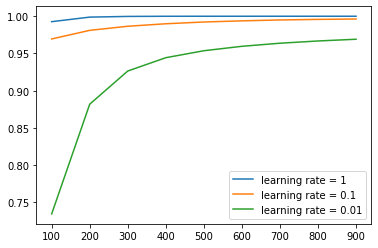

In [90]:
plt.plot(steps, scores_rate1, label='learning rate = 1')
plt.plot(steps, scores_rate01, label='learning rate = 0.1')
plt.plot(steps, scores_rate001, label='learning rate = 0.01')
plt.legend(loc=4)

### Subsample
Reduced subsample to 0.9 to reduce possible over-fitting

In [241]:
from sklearn.metrics import accuracy_score

n_estimators = 1000
gbm.set_params(n_estimators=n_estimators)
steps = list(range(100,1000,100))

In [242]:
gbm.set_params(learning_rate = 0.01, subsample = 0.9)
gbm.fit(newtrain, y)
gen = gbm.staged_predict(newtrain)
scores_subsample09 = []
for n in range(n_estimators):
           predicted_labels = next(gen)
           if n not in steps: continue
           scores_subsample09.append(r2_score(y, predicted_labels))  

In [243]:
gbm.set_params(learning_rate = 0.01, subsample=0.1)
gbm.fit(X_train, y_train)
gen = gbm.staged_predict(X_train)
scores_subsample01 = []
for n in range(n_estimators):
           predicted_labels = next(gen)
           if n not in steps: continue
           scores_subsample01.append(r2_score(y_train, predicted_labels))

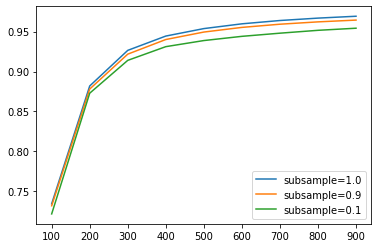

In [244]:
plt.plot(steps, scores_rate001, label = 'subsample=1.0')  # not taking subsample
plt.plot(steps, scores_subsample09, label = 'subsample=0.9')
plt.plot(steps, scores_subsample01, label = 'subsample=0.1')
plt.legend(loc=4)

### Features

In [263]:
sorted_importance = sorted(zip(combine.drop('SalePrice',axis=1), gbm.feature_importances_), key=lambda t:t[1], reverse=True)[:10]
sorted_importance

[('LotArea', 0.43124318193291405),
 ('CentralAir', 0.17144280548756025),
 ('RoofStyle', 0.06913797273863893),
 ('Utilities', 0.05446273008156271),
 ('BsmtQual', 0.04179402227138321),
 ('LotConfig', 0.034993352246120074),
 ('HouseStyle', 0.026743121839801112),
 ('Exterior2nd', 0.023477252121616613),
 ('MSZoning', 0.020260868538896002),
 ('Street', 0.017827456814187417)]

Text(0.5, 1.0, 'Feature Importance Plot of 500-Tree GBM')

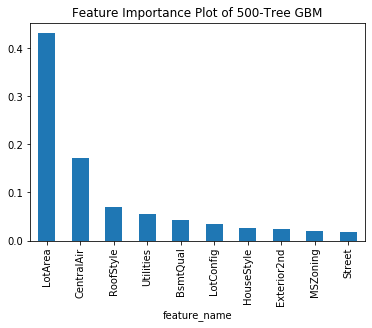

In [264]:
a, b = zip(*sorted_importance) # this splits the list of tuples into two lists
pd.DataFrame({'feature_name':a, 'importance_score':b}).plot.bar(x='feature_name',y='importance_score', legend=None)
plt.title('Feature Importance Plot of 500-Tree GBM')

### Max Depth
Saw no max_depth improvements between 3 & 10 (over-fitting) and 3 & 5 (worst)

In [245]:
n_estimators = 1000
gbm.set_params(n_estimators=n_estimators)
steps = list(range(100,1000,100))
gbm.set_params(max_depth = 5)
    
gbm.fit(X_train, y_train)
gen = gbm.staged_predict(X_train)
r2_maxdepth5 = []
for n in range(n_estimators):
           predicted_targets = next(gen)
           if n not in steps: continue
           r2_maxdepth5.append(r2_score(y_train, predicted_targets)) 

In [246]:
gbm.set_params(learning_rate = 0.1, max_depth = 10)
    
gbm.fit(X_train, y_train)
gen = gbm.staged_predict(X_train)
r2_maxdepth10 = []
for n in range(n_estimators):
           predicted_targets = next(gen)
           if n not in steps: continue
           r2_maxdepth10.append(r2_score(y_train, predicted_targets)) 

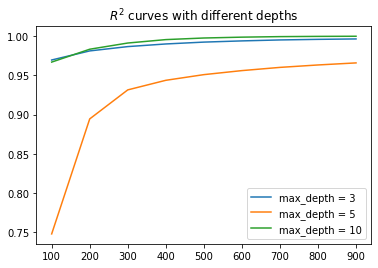

In [247]:
plt.plot(steps, scores_rate01, label='max_depth = 3')
plt.plot(steps, r2_maxdepth5, label='max_depth = 5')
plt.plot(steps, r2_maxdepth10, label='max_depth = 10')
plt.title('$R^2$ curves with different depths')
plt.legend(loc=4)

<p><a name="GBR Prediction"></a></p>

## GBR Prediction

In [1382]:
gbm_predictions = gbm.predict(newtest)

In [1383]:
newtest.loc[:, 'SalePrice'] = gbm_predictions
gbm_predictions = pd.Series(gbm_predictions)

/Users/thisbekristin/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/Users/thisbekristin/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [1384]:
gbm_predictions.shape

(1459,)

In [1385]:
id_no = pd.Series(range(1461,2920))

In [1386]:
GradientBoost = pd.concat([id_no,gbm_predictions],axis=1)

In [1387]:
GradientBoost.columns = ['Id','SalePrice']

In [1388]:
GradientBoost.shape

(1459, 2)

In [1389]:
GradientBoost = GradientBoost.dropna()

In [1390]:
GradientBoost

,Id,SalePrice
0,1461,118092.647154
1,1462,174631.567458
2,1463,187721.160647
3,1464,194759.630134
4,1465,182639.015879
...,...,...
1454,2915,70827.528431
1455,2916,71362.558998
1456,2917,154553.132069
1457,2918,120136.885304


In [663]:
# GradientBoost.to_csv('OriginalGradientBoostPred.csv',index=False)